In [1]:
import numpy as np
import pandas as pd

In [2]:
random_seed = 0

# 3.1 MNIST


In [3]:
import sklearn
from sklearn.datasets import fetch_openml

# Load Data
mnist = fetch_openml('mnist_784', as_frame= False) # set as_frame false since mnist is image, so the df strucuture is inappropriate

# Split data and lable
X, y = mnist.data, mnist.target

# split train and test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

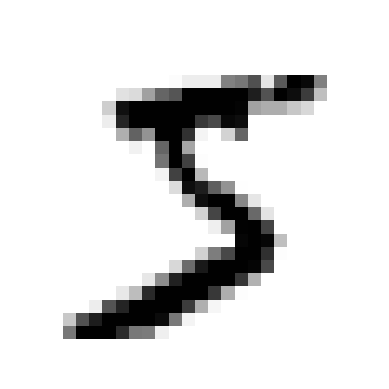

In [4]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
# Show image
some_digit = X_train[0]
plot_digit(some_digit)
plt.show()

# 3.2 Train Binary Classifier

- Train model to predict only "5"


In [5]:
# Set 5 True and others are False
y_train_5 = (y_train =='5')
y_test_5 = (y_test =='5')

### 3.2.1 SGD Classifier

- suitable for a large data set and online learning


In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=random_seed)
sgd_clf.fit(X_train,y_train_5)

sgd_clf.predict([some_digit]) # It's incorrect since the image was actually 5

array([False])

# 3.3 Evaluation


### 3.3.1 Cross Validation


In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring ='accuracy')

array([0.9499, 0.9556, 0.966 ])

### 3.3.2 Custom Cross Validation

- When we need more control with cross validation likewise stratified folding


In [8]:
# Custom K-fold to manage the class imbalancity
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle= True) #StratifiedKFold create fold with keeping class ratio

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.96015
0.96115
0.967


### 3.3.3 Confusion matrix

**Confusion Matrix**

- To analize TP, FP, TN, FN
- Row Represent the True class, and Column represent the predicted class
- First row represent the negative class.
  - (0,0) represent TN
  - (0,1) represent FP {type 1 error}
- Second row represent the positive class.
  - (1,0) represent TP
  - (1,1) represent FN {type 2 error}


In [9]:
from sklearn.metrics import confusion_matrix

y_train_pred = sgd_clf.predict(X_train)
"""
        pred_0 pred_1
true_0   TN    FN
true_1   FP    TP
"""
cm = confusion_matrix(y_train_5, y_train_pred)
print(f"Consusion Maxtrix \n {cm}")

print("--------------------") 


Consusion Maxtrix 
 [[54390   189]
 [ 2127  3294]]
--------------------


### 3.3.4 Precision and Recall

**Precision**

- Accuracy of positive sample prediction
- $Precision = \dfrac{TP}{TP+FP}$

**Recall**

- Ratio of positive samples that the classifier accurately predicted
- Sensitivity or TPR
- $Recall = \dfrac{TP}{TP+FN}$

**F1 Score**

- Harmonic mean of PR and RC


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Precision: {precision_score(y_train_5, y_train_pred)}") 
print(f"Recall: {recall_score(y_train_5, y_train_pred)}") 
print(f"F1 Score: {f1_score(y_train_5, y_train_pred)}") 


Precision: 0.9457364341085271
Recall: 0.6076369673491976
F1 Score: 0.7398921832884097


### 3.3.5 PR and RC trade-off

- Classifier uses decision function and compute the score for each sample, and if the score is greater than the threshold, it classifies as a positive
- The PR and RC has trade-off depends on the threshold
- When threshold gets larger, the Precision gets larger, but the recall gets smalle


In [11]:
y_scores = sgd_clf.decision_function([some_digit])

# False threshold
threshold = 0 
y_some_digit_pred = (y_scores > threshold)
print(f"Score: {y_scores}")
print(f"Threshold: {threshold}")
print(f"Prediction: {y_some_digit_pred}")

# True threshold
threshold = -3000
y_some_digit_pred = (y_scores > threshold)
print(f"Score: {y_scores}")
print(f"Threshold: {threshold}")
print(f"Prediction: {y_some_digit_pred}")

Score: [-2736.11125406]
Threshold: 0
Prediction: [False]
Score: [-2736.11125406]
Threshold: -3000
Prediction: [ True]


### 3.3.6 Get best threshold

1. Compute all score for each sample
2. Draw PR RC curve
3. Look at the curve and decide the threshold


In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

##### 3.3.6.1 PR RC curve 1


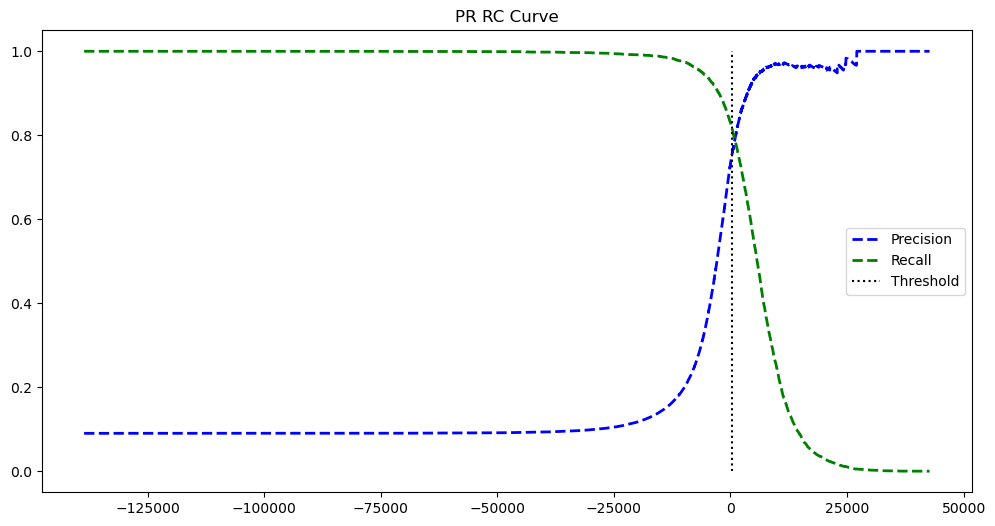

In [13]:
threshold = 400
plt.figure(figsize=(12,6))
plt.plot(thresholds, precisions[:-1], "b--", label = 'Precision', linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--", label = 'Recall', linewidth = 2)
plt.vlines(threshold, 0 , 1.0, "k", "dotted", label='Threshold')
plt.legend()
plt.title('PR RC Curve')
plt.show()

##### 3.3.6.2 PR RC curve 2


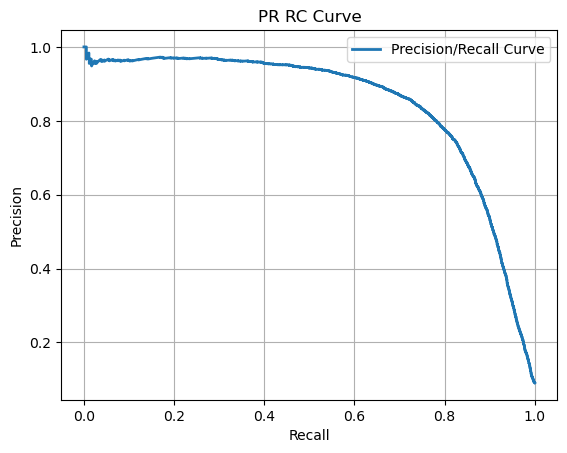

In [14]:
threshold = 400
plt.plot(recalls, precisions, label = 'Precision/Recall Curve', linewidth = 2)
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('PR RC Curve')
plt.show()

#### 3.3.6.3 Achieve a classifier with particular recall/precision rate


In [15]:
idx_for_90_precision = (precisions >= 0.90).argmax() # Get first index of True
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(f"Threshold with 90% precision: {threshold_for_90_precision}")

Threshold with 90% precision: 3611.731693631038


### 3.3.7 ROC Curve

- Receiver operating charateristic is well used for finding binary classification to measure performance\
- ROC draws FPR vs TPR
- From ROC, we can visualize AUC (a good classifier AUC is close to 1)


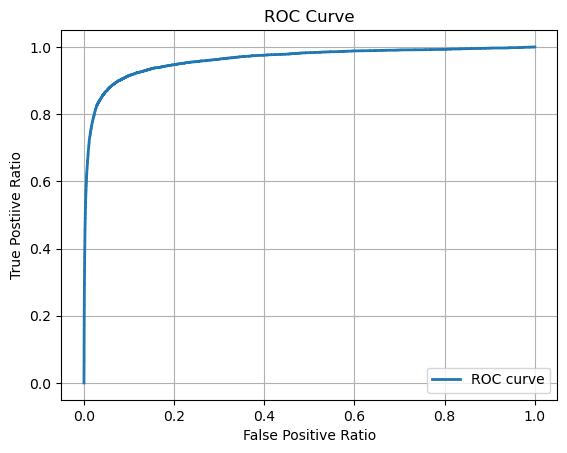

AUC score: 0.9624892334207759


In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth = 2, label = 'ROC curve')
plt.legend()
plt.xlabel('False Positive Ratio')
plt.ylabel('True Postiive Ratio')
plt.grid()
plt.title('ROC Curve')
plt.show()

print(f"AUC score: {roc_auc_score(y_train_5, y_scores)}")

#### 3.3.7.1 Compare SGD with RandomForest

- Random Forest does not provide decision function due to its mechanism
- Rather, we use probabilty to measure the score


In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

forest_clf = RandomForestClassifier(random_state=random_seed)
xgb_clf = XGBClassifier(seed = random_seed)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method="predict_proba")
y_probas_xgb = cross_val_predict(xgb_clf, X_train, y_train_5, cv = 3, method="predict_proba")
print(f"RF predict the first sample is Pos with 81%, and the second sample is Neg with prob 99% \n {y_probas_forest[:2]}") 
print(f"XGB predict the first sample is Pos with 81%, and the second sample is Neg with prob 99% \n {np.round(y_probas_xgb[:2],3)}") 

RF predict the first sample is Pos with 81%, and the second sample is Neg with prob 99% 
 [[0.19 0.81]
 [0.99 0.01]]
XGB predict the first sample is Pos with 81%, and the second sample is Neg with prob 99% 
 [[0.001 0.999]
 [1.    0.   ]]


#### 3.3.7.2 Draw PR RC Curve


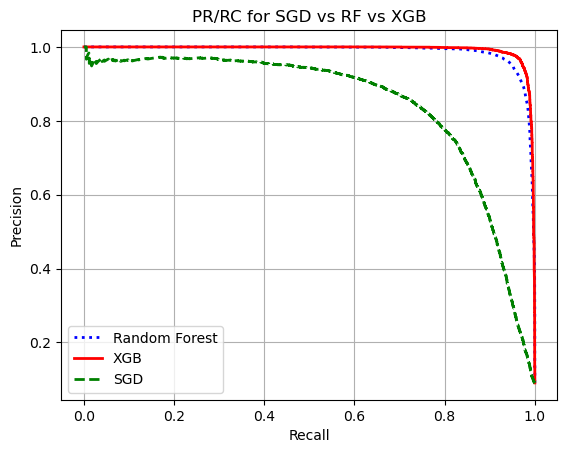

In [18]:
y_scores_forest = y_probas_forest[:, 1] # The second column has prob for positive class
precision_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

y_scores_xgb = y_probas_xgb[:, 1] # The second column has prob for positive class
precision_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_train_5, y_scores_xgb)

plt.plot(recalls_forest, precision_forest, "b:", linewidth = 2, label = "Random Forest")
plt.plot(recalls_xgb, precision_xgb, "r-", linewidth = 2, label = "XGB")
plt.plot(recalls, precisions, "g--", linewidth = 2, label = "SGD")
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.title('PR/RC for SGD vs RF vs XGB')
plt.show()

# 3.4 Multiclass Classifier

- Algorithms like **Logistic Regression**, **Random Forest**, can perform multiclass classifications, but algorithms like **SGD**, **SVC** can only perform binary classification
- But, there are some method(OvR, OvO) to classify multi-class by using multiple binary classifier
  - **OvR or OvA** (one-versus-the-rest): train N models for N lables and select the best score among classifiers Total N models
  - **OvO**(one-versus-all): train for every combination Total N x (N-1) / 2 models
- If we try to train multiclass with binary classifier, scikit-learn will automatically choose either OvA or OvO


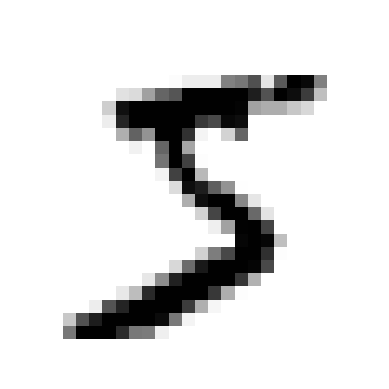

array(['5'], dtype=object)

In [19]:
from sklearn.svm import SVC

svm_clf = SVC(random_state = random_seed)
svm_clf.fit(X_train[:2000], y_train[:2000]) 

plot_digit(some_digit)
plt.show()

svm_clf.predict([some_digit]) # Model correctly predicted the target

### 3.4.1 Descision Function

- **decision_function** returns the descision score for each label
- **classes\_** returns the label


In [20]:
# We can 
print(f"Descision score: {svm_clf.decision_function([some_digit]).round(2)}")
print(f"Classes: {svm_clf.classes_}")
print(f"Prediction: {svm_clf.decision_function([some_digit]).round(2).argmax()}")

Descision score: [[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]
Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Prediction: 5


### 3.4.2 Choose OvA or OvO


In [21]:
from sklearn.multiclass import OneVsRestClassifier

# OvR model
ovr_clf = OneVsRestClassifier(SVC(random_state=random_seed))
ovr_clf.fit(X_train[:10000], y_train[:10000])
print(f"Predcition: {ovr_clf.predict([some_digit])}")

print(f"Number of trained models: {len(ovr_clf.estimators_)}")

Predcition: ['5']
Number of trained models: 10


In [22]:
from sklearn.multiclass import OneVsOneClassifier

# OvO model
ovo_clf = OneVsOneClassifier(SVC(random_state=random_seed))
ovo_clf.fit(X_train[:10000], y_train[:10000])
print(f"Predcition: {ovo_clf.predict([some_digit])}")

print(f"Number of trained models: {len(ovo_clf.estimators_)}")

Predcition: ['5']
Number of trained models: 45


# 3.5 Error Analysis

Method of Error Analysis

1. Analyze error type
   - confusion matrix


### 3.5.1 Confusion Matrix


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


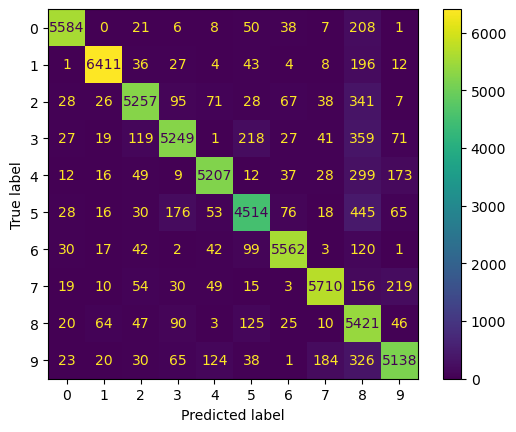

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))

sgd_clf = SGDClassifier(random_state=random_seed)

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()


### 3.5.2 Normalized Confusion Matrix

- We can see the predicting 5 made the most misclassification with 8
- Confusion Matrix is not usually symmetric
- By default, it's normalized by Row -> set normalize = 'pred' normalizes by column


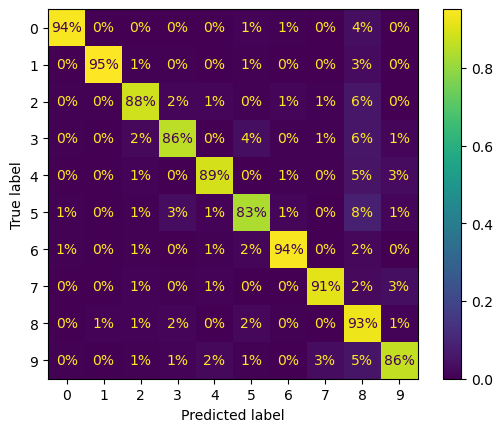

In [25]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format=".0%")
plt.show()

- To make error more visible, we can set the weight to the correct prediction to zero
- From below figure, we can see that the prediction of 8 made the most misclassification


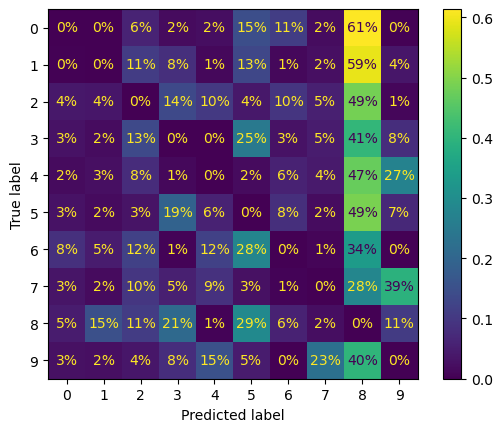

In [27]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize='true', values_format=".0%")
plt.show()

- Normalized by column


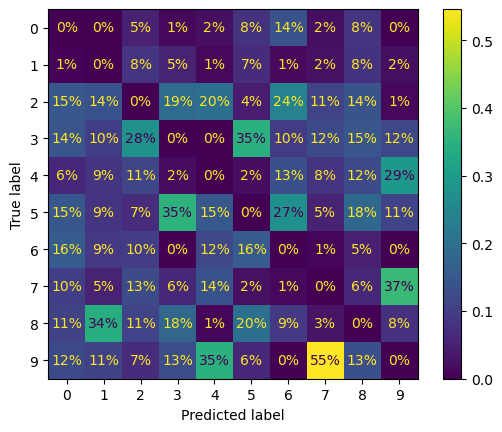

In [28]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize='pred', values_format=".0%")
plt.show()